# Section 1: LLM Ovveview

## LLM Pretraining
LLM is pre-trained to predict the next word.

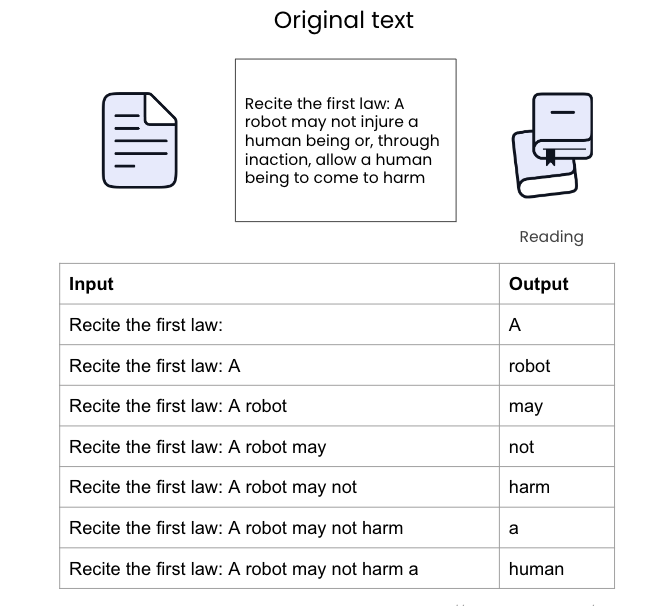

As the size increases, it becomes amazing. However, it is only good at predicting the next word.

`How's the weather today?`
-->
`How's the weather today? and tomorrow?`


## Instruction finetuning

Train the LLM to follow instructions beyond predicting the next word. This changes everything. Now, the LLM can follow your orders.

![image.png](attachment:image.png | width=100)

In [1]:
! pip3 install -q openai langchain_community tiktoken langchain-upstage langchainhub faiss-cpu langchain python-dotenv tavily-python


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [62]:
%load_ext dotenv
%dotenv
# UPSTAGE_API_KEY from https://console.upstage.ai/
# TAVILY_API_KEY https://app.tavily.com
# NEWS_API_KEY from https://newsapi.org/

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [3]:
import os
from openai import OpenAI
from pprint import pprint

client = OpenAI(
    api_key=os.environ["UPSTAGE_API_KEY"], base_url="https://api.upstage.ai/v1/solar"
)
response = client.chat.completions.create(
    model="solar-1-mini-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What about Korea?"},
    ],
)
pprint(response)
print("Message only:")
pprint(response.choices[0].message.content)

ChatCompletion(id='567755dc-ab12-4018-a531-78cdac629e4f', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I'm sorry, I'm not sure what you're asking about Korea. Can you please provide more context or clarify your question?", role='assistant', function_call=None, tool_calls=None))], created=1714534116, model='upstage/solar-1-mini-chat-ko-0108', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=31, prompt_tokens=26, total_tokens=57))
Message only:
("I'm sorry, I'm not sure what you're asking about Korea. Can you please "
 'provide more context or clarify your question?')


In [4]:
# few shots: examples or history
response = client.chat.completions.create(
    model="solar-1-mini-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        # examples
        {"role": "user", "content": "What is the capital of France?"},
        {
            "role": "assistant",
            "content": "I know of it. It's Paris!!",
        },
        # user input
        {"role": "user", "content": "What about Korea?"},
    ],
)
pprint(response)
print("Message only:")
pprint(response.choices[0].message.content)

ChatCompletion(id='88e4d741-80ec-4016-a774-488438120d3f', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Seoul, right?', role='assistant', function_call=None, tool_calls=None))], created=1714534117, model='upstage/solar-1-mini-chat-ko-0108', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=6, prompt_tokens=55, total_tokens=61))
Message only:
'Seoul, right?'


In [5]:
# langchain, 1. llm defule, 2. prompt define, 3. chain, 4. chain.invoke

# 1. define your favorate llm, solar
from langchain_upstage import ChatUpstage
llm= ChatUpstage()

# 2. define chat prompt
from langchain_core.prompts import ChatPromptTemplate
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human", "What is the capital of France?"),
        ("ai", "I know of it. It's Paris!!"),
        ("human", "What about Korea?"),
    ]
)

# 3. define chain 
from langchain_core.output_parsers import StrOutputParser
chain = rag_with_history_prompt | llm | StrOutputParser()

# 4. invoke the chain
response = chain.invoke({})
print(response)

/Users/hunkim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Seoul is the capital of South Korea.


In [6]:
# parameterized prompt template
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human", "What is the capital of France?"),
        ("ai", "I know of it. It's Paris!!"),
        ("human", "What about {country}?"),
    ]
)

chain = rag_with_history_prompt | llm | StrOutputParser()

# 4. invoke chain with param
print(chain.invoke({"country": "Korea"}))
print("---")
print(chain.invoke({"country": "Japan"}))

The capital of North Korea is Pyongyang and the capital of South Korea is Seoul.
---
Oh, that's easy too! It's Tokyo!


In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# More general chat
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

from langchain_core.messages import AIMessage, HumanMessage

history = [
    HumanMessage("What is the capital of France?"),
    AIMessage("It's Paris!!"),
]

chain = rag_with_history_prompt | llm | StrOutputParser()
response = chain.invoke({"history": history, "input": "What about Korea?"})
print(response)

It's Seoul!!


In [8]:
from langchain_upstage import (
    UpstageLayoutAnalysisLoader,
    UpstageGroundednessCheck,
    ChatUpstage,
    UpstageEmbeddings,
)
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter


layzer = UpstageLayoutAnalysisLoader("./solar_paper_sample.pdf", output_type="html")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
docs = layzer.load()  # or layzer.lazy_load()

In [9]:
for doc in docs:
    pprint(doc.page_content)

("<table id='0' "
 "style='font-size:14px'><thead></thead><tbody><tr><td>Model</td><td>Alpaca-GPT4</td><td>OpenOrca</td><td>Synth. "
 'Math-Instruct</td><td>H6 '
 '(Avg.)</td><td>ARC</td><td>HellaSwag</td><td>MMLU</td><td>TruthfulQA</td><td>Winogrande</td><td>GSM8K</td></tr><tr><td>SFT '
 'v1</td><td>0</td><td>X</td><td>X</td><td>69.15</td><td>67.66</td><td>86.03</td><td>65.88</td><td>60.12</td><td>82.95</td><td>52.24</td></tr><tr><td>SFT '
 'v2</td><td>0</td><td>O</td><td>X</td><td>69.21</td><td>65.36</td><td>85.39</td><td>65.93</td><td>58.47</td><td>82.79</td><td>57.32</td></tr><tr><td>SFT '
 'v3</td><td>0</td><td>O</td><td>O</td><td>70.03</td><td>65.87</td><td>85.55</td><td>65.31</td><td>57.93</td><td>81.37</td><td>64.14</td></tr><tr><td>SFT '
 'v4</td><td>0</td><td>X</td><td>0</td><td>70.88</td><td>67.32</td><td>85.87</td><td>65.87</td><td>58.97</td><td>82.48</td><td>64.75</td></tr><tr><td>SFT '
 'v3 + '
 'v4</td><td>0</td><td>0</td><td>0</td><td>71.11</td><td>67.32</td><td>85.96</

In [10]:
# More general chat
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question considering the history of the conversation. 
If you don't know the answer, just say that you don't know. 
---
CONTEXT:
{context}
         """,
        ),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

from langchain_core.messages import AIMessage, HumanMessage

history = [
]

chain = rag_with_history_prompt | llm | StrOutputParser()
query1 = "Performance comparison amongst the merge candidate"
response1 = chain.invoke({"history": history, "context": docs, "input": query1})
print("RESPONSE1\n", response1)


RESPONSE1
 The performance comparison amongst the merge candidates is shown in Table 6. The table includes the H6 (Average) score, ARC score, HellaSwag score, MMLU score, TruthfulQA score, Winogrande score, and GSM8K score for each merge candidate. The best scores for H6 and the individual tasks are shown in bold.


In [11]:
history = [
    HumanMessage(query1),
    AIMessage(response1)
]
query2 = "How about Ablation studies?"
response2 = chain.invoke({"history": history, "context": docs, "input": query2})
print("RESPONSE2\n", response2)

RESPONSE2
 Ablation studies are experiments that systematically remove certain components or features of a model to analyze their impact on the model's performance. In the context you provided, the ablation studies are focused on understanding the impact of different datasets (SFT v1, SFT v2, SFT v3, SFT v4, OpenOrca, Synth. Math-Instruct, Ultrafeedback Clean, and Synth. Math-Alignment) on the model's performance.


In the first ablation study (Table 3), the addition of the OpenOrca dataset to SFT v1 resulted in a slight improvement in the GSM8K score but noticeably lower scores for ARC, HellaSwag, and TruthfulQA. When Synth. Math-Instruct was added to SFT v3, the performance was improved for all tasks, with SFT v4 having the highest H6 score of 70.8.


In the second ablation study (Table 4), it is observed that Ultrafeedback Clean and Synth. Math-Alignment impact model performance. DPO v1, trained only with Ultrafeedback Clean, achieved a higher H6 score compared to the SFT base model

In [12]:
# Let's load something big
layzer = UpstageLayoutAnalysisLoader("./solar_paper.pdf", output_type="html")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
docs = layzer.load()  # or layzer.lazy_load()

In [13]:
chain = rag_with_history_prompt | llm | StrOutputParser()
query1 = "What is DUS? WHy it's good?"
try:
    response1 = chain.invoke({"history": history, "context": docs, "input": query1})
    print(response)
except Exception as e:
    print("Error", e)

Error Error code: 400 - {'error': {'message': "This model's maximum context length is 16384 tokens. However, your messages resulted in 21350 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


In [14]:
# RAG 1. load doc (done), 2. chunking, splits, 3. embeding - indexing, 4. retrieve 

# 2. Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(docs)
print("Splits:", len(splits))

# 3. Embed & indexing
vectorstore = FAISS.from_documents(documents=splits, embedding=UpstageEmbeddings())
retriever = vectorstore.as_retriever(k=10)

# 4. retrive
result_docs = retriever.invoke("What is DUS?")
print(result_docs[1])

Splits: 132
page_content="al., 2023).</p><br><p id='133' style='font-size:14px'>Departing from the horizontal expansion char-<br>acteristic of MoE models, the DUS method intro-</p><p id='134' style='font-size:16px'>duces model scaling in the vertical dimension. No-<br>tably, DUS does not introduce dynamism in the<br>scaled model, which significantly reduces the com-<br>plexity when compared to MoE. This shift in ap-<br>proach offers a unique and more straightforward<br>way of working, moving away from" metadata={'total_pages': 10, 'type': 'html', 'split': 'none'}


In [15]:
# Finally query using RAG
query = "What is DUS?"
result_docs = retriever.invoke(query)

response = chain.invoke({"history": history, "context": result_docs, "input": query})
print(response)

DUS stands for Depth Up-Scaling. It is a method of scaling up language models by increasing the depth of the model in a specific manner. DUS introduces model scaling in the vertical dimension, departing from the horizontal expansion characteristic of other methods such as the Multi-Head Mechanical Turk (MHT) model and the Multi-Expert (MoE) model. DUS does not introduce dynamism in the scaled model, which significantly reduces the complexity compared to MoE. One limitation of DUS is the need for more thorough exploration of hyperparameters used in the DUS approach.


In [16]:
history = [
    HumanMessage(query),
    AIMessage(response)
]

query = "Why it is good?"
result_docs = retriever.invoke(query)

response = chain.invoke({"history": history, "context": result_docs, "input": query})
print(response)

DUS (Depth Up-Scaling) is considered a good approach for scaling up language models because it offers several advantages. It is computationally efficient compared to other methods like MoE, which makes it more practical for large scale training. Additionally, DUS maintains the simplicity of the base model, which helps to avoid some of the complexities introduced by other scaling methods. This simplicity can also lead to better generalization performance. DUS also provides a way to build large models using a subset of available parameters, which can be useful in situations where resources are limited. Overall, DUS offers a practical and efficient solution for scaling up language models.


In [17]:
from langchain_upstage import ChatUpstage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate


def query_expander(query):
    # Multi Query: Different Perspectives
    multi_query_template = """You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines. Original question: {query}"""

    # RAG-Fusion: Related
    rag_fusion_template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
    Generate multiple search queries related to: {query} \n
    Output (4 queries):"""

    # Decomposition
    decomposition_template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
    Generate multiple search queries related to: {query} \n
    Output (3 queries):"""

    query_expander_templates = [
        multi_query_template,
        rag_fusion_template,
        decomposition_template,
    ]

    expanded_queries = []
    for template in query_expander_templates:
        prompt_perspectives = ChatPromptTemplate.from_template(template)

        generate_queries = (
            prompt_perspectives
            | ChatUpstage(temperature=0)
            | StrOutputParser()
            | (lambda x: x.split("\n"))
        )
        expanded_queries += generate_queries.invoke({"query": query})

    return expanded_queries


expanded_queries = query_expander("What is the DUS approach developed by Upstage?")
pprint(expanded_queries)

['1. Explain the DUS approach created by Upstage.',
 '2. What is the DUS approach and who developed it?',
 '3. Can you provide information about the DUS approach developed by Upstage?',
 '4. Describe the DUS approach developed by Upstage in detail.',
 '5. How does the DUS approach developed by Upstage work?',
 '1. What are the key components of the DUS approach developed by Upstage?',
 '2. How does the DUS approach by Upstage differ from other user experience '
 'design methods?',
 '3. What are the benefits of using the DUS approach in user experience '
 'design?',
 '4. Can you provide examples of successful implementations of the DUS '
 'approach by Upstage?',
 '1. "What is the DUS approach developed by Upstage?"',
 '2. "What are the key components of the DUS approach developed by Upstage?"',
 '3. "How does the DUS approach developed by Upstage differ from other '
 'approaches in the field?"']


In [18]:
# Finally query using RAG
oroginal_query = "What is DUS? Why it is good?"
expanded_queries = query_expander(query)
expanded_queries.append(oroginal_query)

expended_result_docs = []
for query in expanded_queries:
    print("Search for: ", query)
    result_docs = retriever.invoke(query)
    expended_result_docs.append(result_docs)

# remove duplicates 
unique_docs = (list(set(expanded_queries)))
print("expended_result_docs", len(expended_result_docs))
print("Unique docs:", len(unique_docs))

response = chain.invoke({"history": history, "context": expanded_queries, "input": query})
print(response)

Search for:  1. What are the benefits of it?
Search for:  2. What makes it a positive choice?
Search for:  3. What are the advantages of using it?
Search for:  4. What makes it a good option?
Search for:  5. What are the positive aspects of it?
Search for:  1. Benefits of being good
Search for:  2. Good deeds and their impact
Search for:  3. Moral philosophy: the value of goodness
Search for:  4. Goodness in relationships and society
Search for:  1. What are the benefits of using it?
Search for:  2. What are the positive attributes of it?
Search for:  3. What are the advantages of using it over alternatives?
Search for:  What is DUS? Why it is good?
expended_result_docs 13
Unique docs: 13
DUS stands for Depth Up-Scaling. It is a method of scaling up language models by increasing the depth of the model in a specific manner. DUS introduces model scaling in the vertical dimension, departing from the horizontal expansion characteristic of other methods such as the Multi-Head Mechanical Tur

In [19]:
# RAG or Search?
def is_in(question, context):
    is_in_conetxt = """You are a helpful assistant and have a good understanding on 
context and questions. Using your best judgement, please check if the answer of the question is in the given context.
If answer is on the context, please returen yes. Otherwise resturn yes. 
Only resturn yes or no. Please do not include any additional information.
Please do youe best. Here are question and the context:
---
QUESTION: {question}

CONTEXT: {context}

Output (yes or no):"""

    is_in_prompt = ChatPromptTemplate.from_template(is_in_conetxt)
    chain = is_in_prompt | ChatUpstage() | StrOutputParser()

    response = chain.invoke({"history": [], "context": context, "question": question})
    print(response)
    return response.lower().startswith("yes")

In [20]:
question = "Can you tell me about Sung Kim's life?"
context = retriever.invoke(question)
print(is_in(question, context))

no
False


In [21]:
question = "What is DUS?"
context = retriever.invoke(question)
print(is_in(question, context))

yes.
True


In [22]:
# Smart RAG, Self-Improving RAG
from tavily import TavilyClient

def smart_rag(question):
    context = retriever.invoke(question)
    if not is_in(question, context):
        print("Searching in tavily")
        tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
        context  = tavily.search(query=question)

    chain = rag_with_history_prompt | llm | StrOutputParser()
    return chain.invoke({"history": history, "context": context, "input": question})


In [23]:
question = "What is DUS?"
smart_rag(question)


yes


'DUS stands for Depth Up-Scaling. It is a method of scaling up language models by increasing the depth of the model in a specific manner. DUS introduces model scaling in the vertical dimension, departing from the horizontal expansion characteristic of other methods such as the Multi-Head Mechanical Turk (MHT) model and the Multi-Expert (MoE) model. DUS does not introduce dynamism in the scaled model, which significantly reduces the complexity compared to MoE. One limitation of DUS is the need for more thorough exploration of hyperparameters used in the DUS approach.'

In [24]:
question = "What's the population of San Francisco?"
smart_rag(question)

no.
Searching in tavily


"As per the provided context, the current population of San Francisco in 2024 is 3,343,000 according to MacroTrends. However, it's worth noting that this is a projection and not the actual population as of now. The official estimate for 2010-2019 is not available as of the February 2023 publication, according to the San Francisco's official website."

In [25]:
# GC
from langchain_upstage import UpstageGroundednessCheck

groundedness_check = UpstageGroundednessCheck()

request_input = {
    "context": str(unique_docs),
    "answer": response,
}
response = groundedness_check.invoke(request_input)

print(response)
if response.lower().startswith("grounded"):
    print("✅ Groundedness check passed")
else:
    print("❌ Groundedness check failed")

grounded
✅ Groundedness check passed


In [57]:
# Tools
from langchain_core.tools import tool
import requests

@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b

@tool
def get_news(topic: str) -> str:
    """Get news on a given topic."""
    # https://newsapi.org/v2/everything?q=tesla&from=2024-04-01&sortBy=publishedAt&apiKey=API_KEY
    # change this to request news from a real API
    news_url = f"https://newsapi.org/v2/everything?q={topic}&apiKey={os.environ['NEWS_API_KEY']}"
    respnse = requests.get(news_url)
    return respnse.json()

tools = [add, multiply, get_news]

In [58]:
llm_with_tools = llm.bind_tools(tools)


In [67]:
query = "What's news on NewJeans?"

tool_calls = llm_with_tools.invoke(query).tool_calls
print(tool_calls)

[{'name': 'get_news', 'args': {'topic': 'NewJeans'}, 'id': 'd98a7c0c-a5b8-4a69-8dc3-c5bcfb8e9ddc'}]


In [ ]:
def call_tool(tool_call):
    tool_name = tool_call["name"].lower()
    if tool_name not in globals():
        print("Tool not found", tool_name)
        return None
    selected_tool = globals()[tool_name]
    return selected_tool.invoke(tool_call["args"])

In [68]:
for tool_call in tool_calls:
    #selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    print(call_tool(tool_call))

{'status': 'ok', 'totalResults': 287, 'articles': [{'source': {'id': 'the-verge', 'name': 'The Verge'}, 'author': 'Amrita Khalid', 'title': 'You don’t know your K-pop persona, do you?', 'description': 'The streaming service has launched a quiz to celebrate K-pop fans and commemorate the genre’s global success.', 'url': 'https://www.theverge.com/2024/4/23/24138370/spotify-launches-k-pop-persona-quiz', 'urlToImage': 'https://cdn.vox-cdn.com/thumbor/R8QosYN1HjNZ4_t68kbgPVzO0h8=/0x0:2216x1172/1200x628/filters:focal(1108x586:1109x587)/cdn.vox-cdn.com/uploads/chorus_asset/file/25414136/Screen_Shot_2024_04_23_at_9.07.24_AM.png', 'publishedAt': '2024-04-23T18:17:24Z', 'content': 'You dont know your K-pop persona, do you?\r\nYou dont know your K-pop persona, do you?\r\n / Dont be super shy. Spotify does.\r\nByAmrita Khalid, one of the authors of audio industry newsletter Hot Pod. Kh… [+2160 chars]'}, {'source': {'id': None, 'name': 'Stereogum'}, 'author': 'Danielle Chelosky', 'title': 'NewJeans

In [64]:
query = "What is 3 * 12? Also, what is 11 + 49?"

tool_calls = llm_with_tools.invoke(query).tool_calls
print(tool_calls)

[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': '17b85187-b41c-4c7f-8835-298871998306'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'c1dcb9a8-c857-4b90-996a-529cf854e666'}]


In [66]:
for tool_call in tool_calls:
    print(call_tool(tool_call))


36 from {'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': '17b85187-b41c-4c7f-8835-298871998306'}
60 from {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'c1dcb9a8-c857-4b90-996a-529cf854e666'}
